# Power consumption of Tetouan City, Morocco

This notebook is my take on the work done in *Comparison of Machine Learning Algorithms for the Power Consumption Prediction: Case Study of Tetouan city* (Salam and El Hibaoui 2018, in *2018 6th International Renewable and Sustainable Energy Conference*). My purpose in doing this is, firstly, to increase my familiarity with techniues of machine learning, and secondly to demonstrate my knowledge for anyone who might be interested.

The original paper and the dataset used may be found on the UC Irvine ML repository [here](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city).

## The original work, and my approach

The original paper uses various ML algorithms to predict the power demand in three electrical supply networks serving Tetouan City, Morocco, based on environmental factors. The dataset used consists of observations of the input and output variables taken every 10 minutes during 2017.

I found the paper's description of the method used to be somewhat unclear, and so I have attempted to implement a method which best fits what is described in the paper while also following correct machine learning methodology as I currently understand it. Thus this notebook is not an exact reimplementation of what is in the paper.

I have not been able to work with the full dataset here, nor consider as wide a range of values for each hyperparameter as in the original paper, due to the limited computational resources available to me. Fully recreating the original work would (I think) produce a notebook that would take many days to run on my system. I have compromised by resampling the original dataset to have just one datapoint per hour, rather than per 10 minute period (this resampling was also considered in the original paper) and restricting the range of hyperparameters to a few values close to the optimal values found in the original paper.


### Dataset citation and License
The citation for the dataset used here is: Salam, A., & El Hibaoui, A. (2018, December) *Comparison of Machine Learning Algorithms for the Power Consumption Prediction: Case Study of Tetouan city*, in *2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5) IEEE*. The dataset is used under a Creative Commons Attribution 4.0 International (CC BY 4.0) license (see the UC Irvine page above for more information).

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display, HTML, Markdown

import datetime

## 1 - Read and prepare data

Firstly, we read in the data and preprocess it by
1. resampling it to have 1 datapoint per hour, rather than 1 datapoint per 10 minutes
2. separating the input variables and target variables.
3. normalizing the input variables via min-max normalization (as in the original paper).

Note that each record in the data contains a measurement of the power demand in each of the three networks (called "Zones" in the column headings), and we shall be interested in predicting the demand in all three of the networks separately based on the input variables. Thus, we are effectively consdering three separate regression problems in parallel.

In [2]:
data = pd.read_csv('Tetuan City power consumption.csv',parse_dates=['DateTime'])

# Two of the original column names contain an extraneous space, so we remove these
col_renames = {f"Zone {n}  Power Consumption":f"Zone {n} Power Consumption" for n in (2,3)}
data = data.rename(columns=col_renames)

# Resample the data to have a data point every hour (rather than every 10 minutes)
data = data.set_index('DateTime')
data = data.resample('1H').mean()
data = data.reset_index()

# Extract the input variables and the three target variables
data = data.drop('DateTime',axis=1)
feature_col_names = {k:f"Zone {k} Power Consumption" for k in (1,2,3)}
input_data = data.drop(feature_col_names.values(),axis=1).to_numpy()
target_data = {k:data[feature_col_names[k]].to_numpy() for k in (1,2,3)}

# We perform min-max normalization on all input variables, as in the original paper
input_data=(input_data-input_data.min())/(input_data.max()-input_data.min())

# Report on the number of datapoints
print(f"{input_data.shape[0]} datapoints in final dataset")

8736 datapoints in final dataset


## 2 - Perform hyperparameter tuning and model fitting

Following the original paper, we shall investigate the following ML algorithms: Random Forest (RF), Decision Tree (DT), Support Vector Machine (SVM), and Linear Regression (LR). Of these, RF, DT and SVM have tunable hyperparameters, and we shall tune these via a grid search with cross-validation, as implemented in the scikit-learn class GridSearchCV. LR does not have any hyperparameters, and is mainly included here as a "baseline" model against which the others may be judged. As in the original paper, we shall use both Mean Absolute Error (MAE)

The method I implement below is as follows. For each zone (numbers 1,2,3), we do a 5-fold repetition of the following process:

 1. Split the data randomly into a 25% test set and a 75% train set.
 2. For combination of model (RF, DT, SVM, LR) and performance metric (MAE or RMSE), do the following:
        i. If the model has tunable hyperparameters, tune these via a grid search with 5-fold cross-validation
           on the training set, using the chosen performance metric. Record these tuned hyperparameters for
           later use.
        ii. Fit the model (with any tuned hyperparameter values) on the training set.
        iii. Record the fitted model's performance on the test set (using the chosen metric).
        
For RF, we repeat steps 2\.ii and 2\.iii 5 times at each iteration and take the mean score to smooth out a bit of
the variability in the process. Note that we perform the test-train split at the start of each iteration and use the same split for all models in each iteration to ensure fair comparison.

The final product of this process is, for each combination of zone, model, and performance metric, a list of 5 performance scores and (if the model is not LR) a list of the tuned parameters which produced these performance scores. These results will then be reported and analysed in the next step.

### Choosing the search space for the parameters
For the models with tunable hyperparameters, steps 2\.i and 2\.ii above are both done via scikit-learn's GridSearchCV class. For this we need to define the parameter values to be searched for each parameter in each model. I have not been able to choose as large a range of values to search as the origial paper due to the limited computational resources available to me, so I have for each parameter chosen just a few values based on the best values reported for the full (i.e. every 10 minute) dataset, as reported in section IV of the original paper.

In [3]:
# define the parameter values to search
RF_params = {
    'n_estimators':[20,30,40],
    'max_features':[6,7,8],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3]}
DT_params = {
    'min_samples_split':[9,10,11],
    'min_samples_leaf':[9,10,11],
    'max_features':[8,9,10]}
SVM_params = {
    'C':[1, 10, 100],
    'gamma':[0.001, 0.01, 0.001]}

# set up the configurations for the grid searches
gridsearch_configs = [
    ['Random Forest','RF',RF_params,RandomForestRegressor()],
    ['Decision Tree','DT',DT_params,DecisionTreeRegressor()],
    ['Support Vector Machine','SVM',SVM_params,SVR()]]
 

### Running the grid searches and fitting the models

We now carry out the process described above. I have included some code to print progress messages as the computation proceeds, since this code takes around 10 hours to run on my system and I find it helpful to have an idea of what is happening. I have, however, removed this output before publishing this notebook, as it is no longer relevant after the notebook has run.

In [ ]:
# function to print progress reports
def prt_time(msg):
    ts = datetime.datetime.now().strftime('%H:%M:%S')
    print(f"{msg} [{ts}]")

# set up the configurations for the two different metrics (MAE and RMSE) we want to use
metric_configs = [
    ['MAE','neg_mean_absolute_error',mean_absolute_error],
    ['RMSE','neg_root_mean_squared_error',lambda a,b: mean_squared_error(a,b,squared=False)]]

# create structures to store the results (performance scores and best parameters)
zone_metric_pairs = list(itertools.product((1,2,3),('MAE','RMSE')))  # all combinations of a zone and a metric,
                                                                     # will be reused later
results = {} # to score performance scores
for k1 in ['RF','DT','SVM','LR']:
    results[k1]={}
    for k2 in zone_metric_pairs:
        results[k1][k2]=[]       
best_params= {} # to store best parameters
for k1 in ['RF','DT','SVM']:
    best_params[k1]={}
    for k2 in zone_metric_pairs:
        best_params[k1][k2]=[]

repeat_count= 5   # how many times to repeat the whole process for each zone
RF_runs_count= 5  # how many runs to average each score over for RF
for zone in (1,2,3):
    prt_time(f"starting zone {zone}")
    for i in range(0,repeat_count):
        prt_time(f"  starting zone {zone}, loop {i+1}")
        X_train, X_test, y_train, y_test = train_test_split(input_data, target_data[zone], test_size=0.25)

        # do all models which have tunable hyperparameters
        for est_name,est_abbr,grid_params,est in gridsearch_configs:
            for metric_abbr,metric_score_name,metric_func in metric_configs:
                prt_time(f"    starting zone {zone}, loop {i+1}, {est_abbr}, {metric_abbr}")

                # do the grid search
                gs = GridSearchCV(est,grid_params,scoring=metric_score_name)
                gs.fit(X_train,y_train)
                
                # score the model and record the result
                if est_name == 'Random Forest':
                    # for RF, average the perfomance score over several runs
                    est = gs.best_estimator_
                    cum_score = 0
                    for _ in range(0,RF_runs_count):
                        est.fit(X_test,y_test)
                        cum_score += metric_func(y_test,est.predict(X_test))
                    results['RF'][(zone,metric_abbr)].append(cum_score/RF_runs_count) # record performance score
                    best_params['RF'][(zone,metric_abbr)].append(gs.best_params_) # record best parameters
                else:
                    # in this case, GridSearchCV.fit() has already refit the estimator with the best parameters
                    # on the whole test set
                    score = metric_func(y_test,gs.predict(X_test))
                    results[est_abbr][(zone,metric_abbr)].append(score) # record performance score
                    best_params[est_abbr][(zone,metric_abbr)].append(gs.best_params_) # record best parameters

        # fit and score the linear regression estimator (which has no tunable hyperparameters)
        est = LinearRegression()
        est.fit(X_train,y_train)
        for metric_abbr,_,metric_func in metric_configs:
            prt_time(f"    starting zone {zone}, loop {i+1}, LR, {metric_abbr}")
            results['LR'][(zone,metric_abbr)].append(metric_func(y_test,est.predict(X_test)))

## 3 - Process and present the results

We present two different sets of results: a summary of the performances of the various algorithm, and some bar charts showing the distribution of the best parameter values across the various runs.

### Performance scores
We construct a table showing, for each model and each combination of zone and error metric, the mean, median, and standard deviation of the scores achieved by that model using the best hyperparameter values for the data from that zone, assessed using that metric.

To be more explicit about what the following table shows, note that for each combination of model, zone, and error metric, we have five scores from the computation in section 2 above. Each of these scores was obtained by taking a train-test split of the data from that zone, tuning the hyperparameters on the training set via cross-validation to minimise the chosen error metric, refitting the model on the whole training set using the tuned hyperparameter values, and then recording the trained model's score (by the chosen error metric). For each set of five scores, we display the mean, median, and standard deviation, and highlight the lowest score in each column in bold.

In [5]:
# pull the information for the rows of our table out of the stored data from the computations above
rows = []
for est_abbr in results:
    row = [est_abbr]
    for zm_pair in zone_metric_pairs:
        scores = results[est_abbr][zm_pair]
        row += [np.mean(scores),np.median(scores),np.std(scores)]
    rows.append(row)

# put the rows into a dataframe, and display it nicely
col_names = ['Model']+[(f"Zone {z}",mn,stat) for z,mn in zone_metric_pairs for stat in ('mean','median','std dev')]
scores_df = pd.DataFrame(rows,columns=col_names)
scores_df = scores_df.set_index('Model')
scores_df.columns = pd.MultiIndex.from_tuples(scores_df.columns)
scores_df.style.format(precision=3).apply(
    lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

As we can see from the table, Random Forest performs the best by both MAE and RMSE in all three zones, and moreover it outperforms the other models significantly. A somewhat surprising result is that Linear Regression, which (as stated above) was originally included as a "baseline" model for comparison, actually outperforms SVM somewhat in all zones.

### Distribution of best hyperparameter values

Finally, for each model and each hyperparameter to that model which was considered in the grid search above, we make bar charts to show how frequently each value of the hyperparameter was selected as the best. We produce two series of bar charts: the first series displays the total number of times each hyperparameter value was selected as the best across all three zones, while the second series shows the number of times each hyperparameter value was selected as the best in each of the three zones. In both series we draw separate graphs for the hyperparameter values obtained using MAE and RMSE as error metrics

## Totals

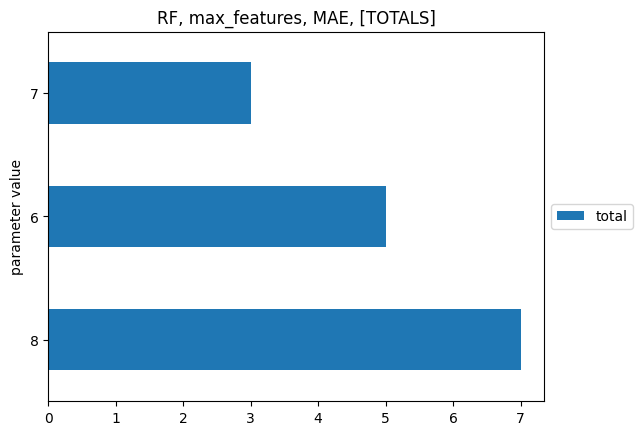

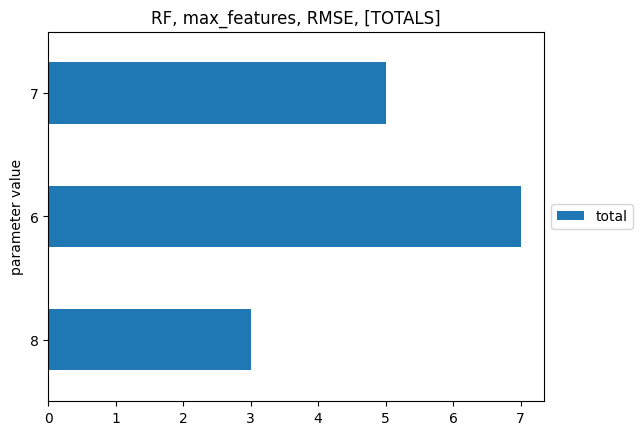

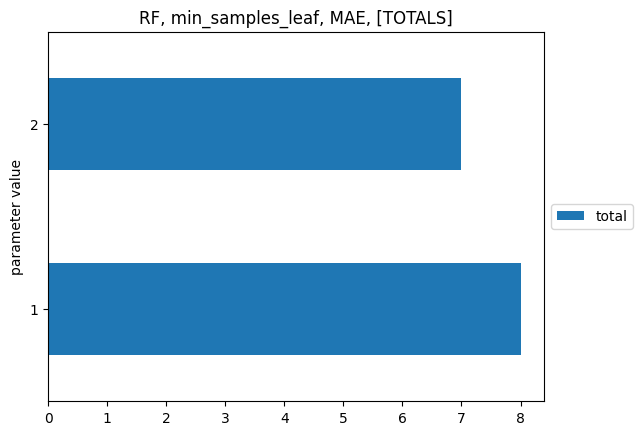

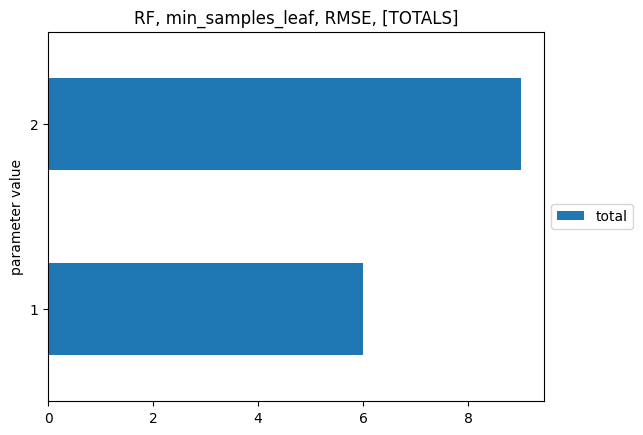

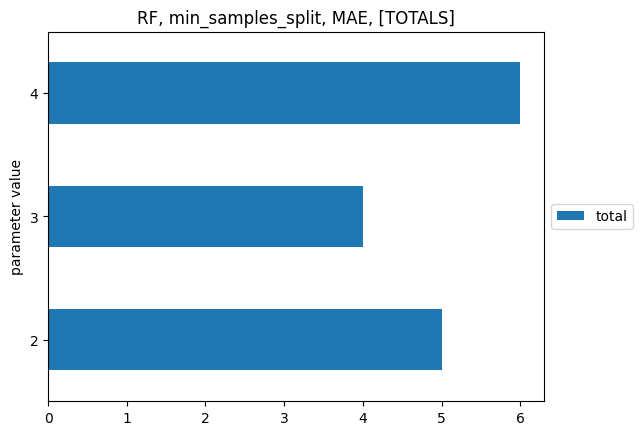

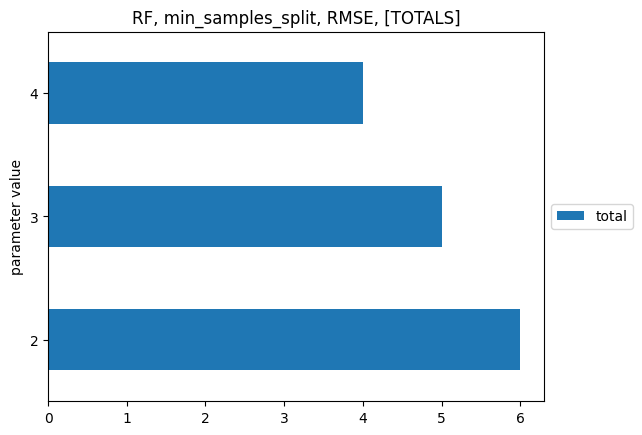

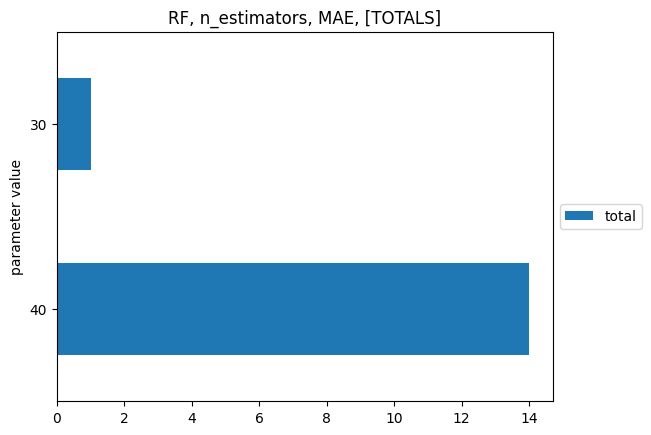

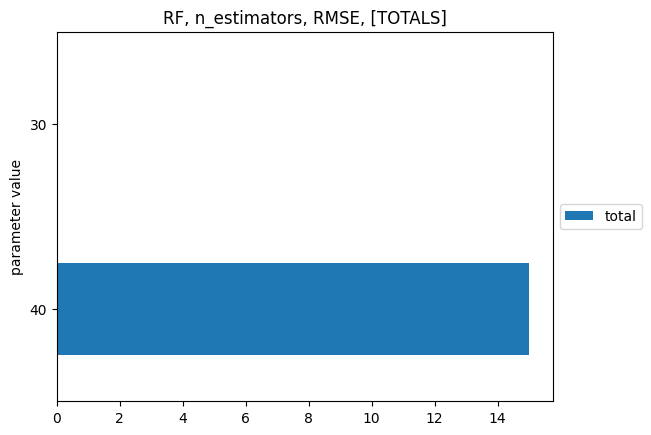

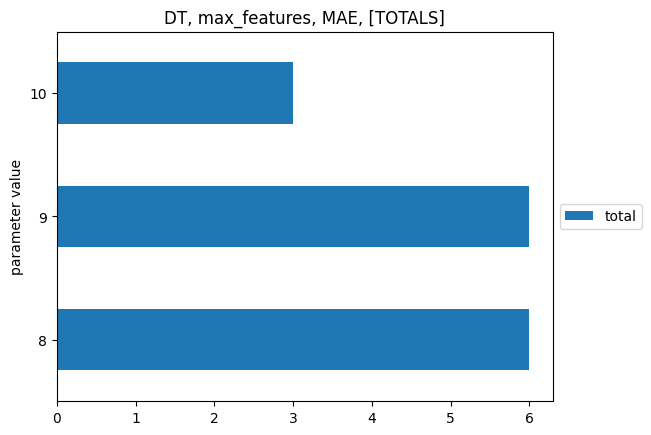

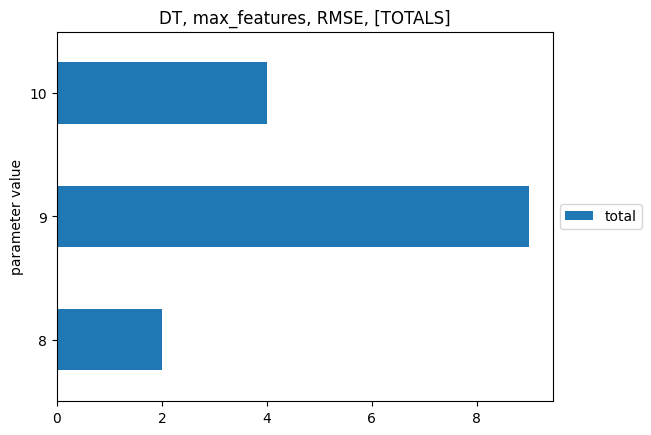

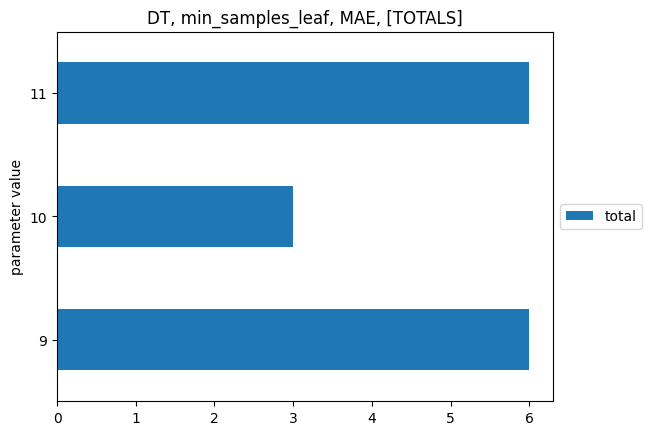

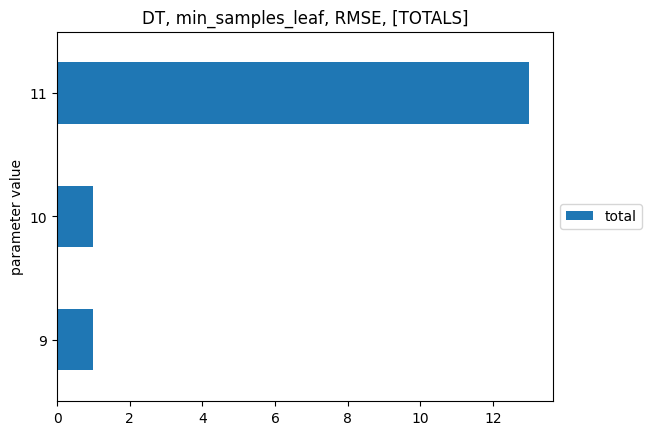

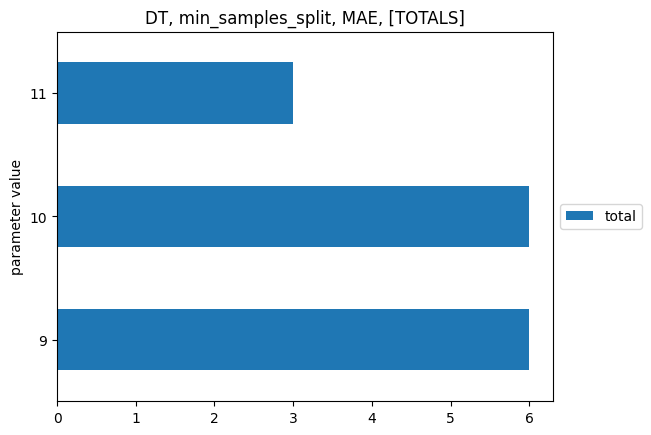

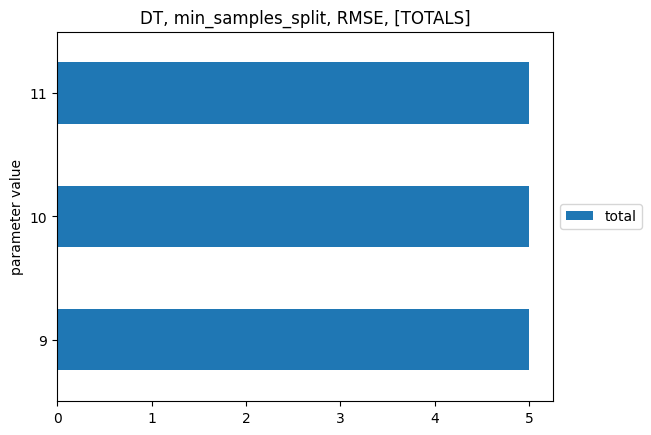

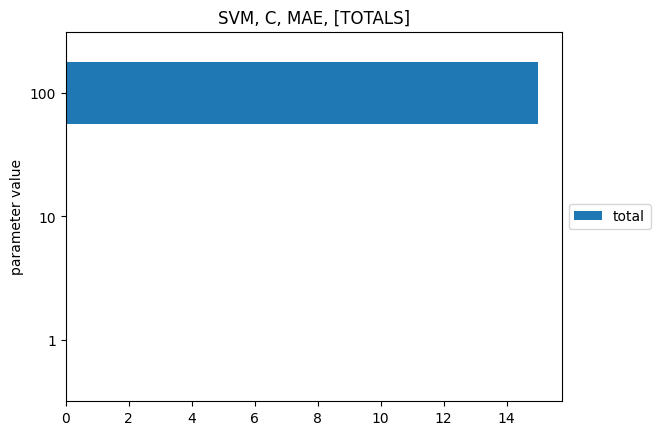

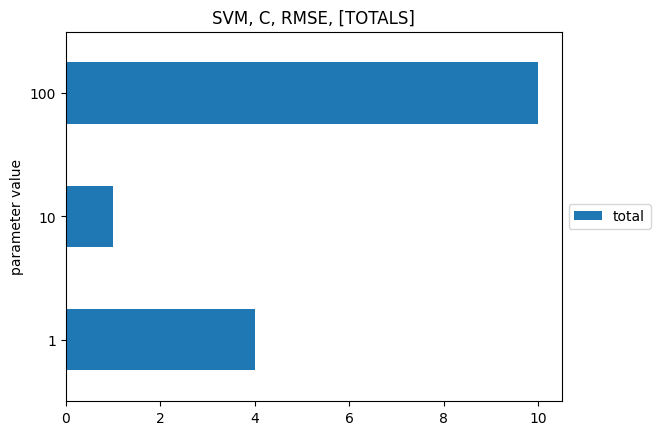

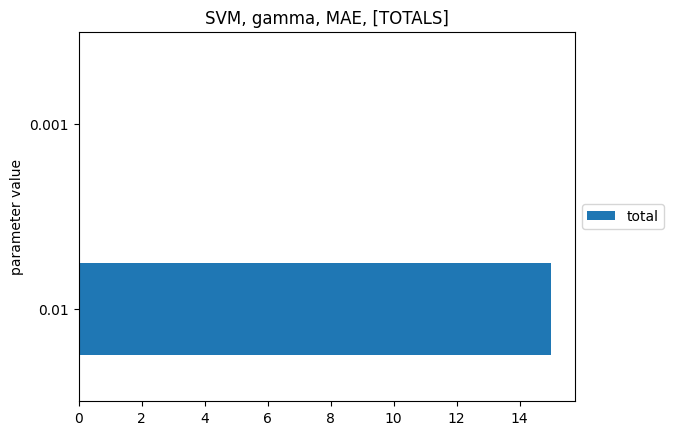

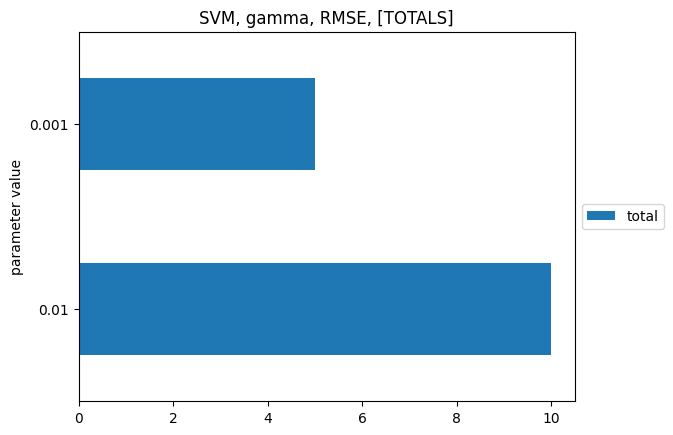

## Breakdowns

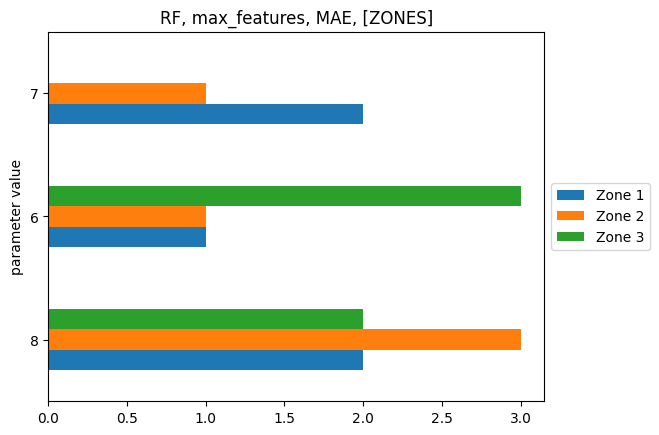

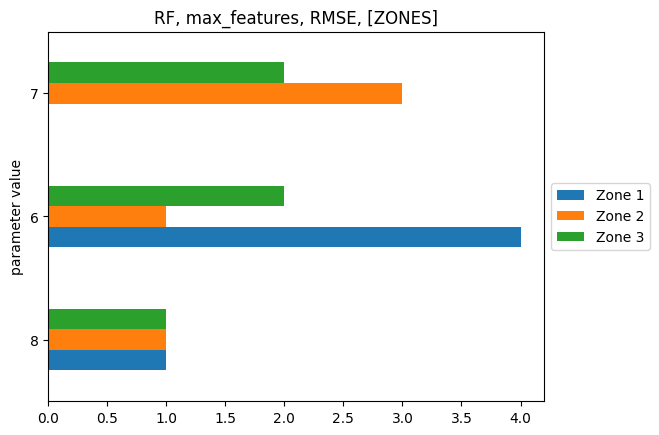

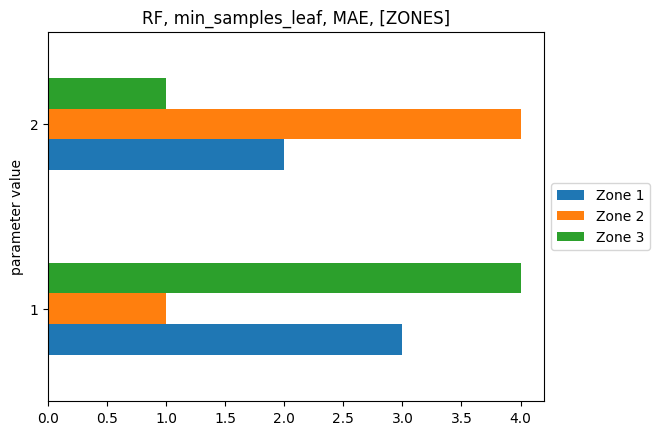

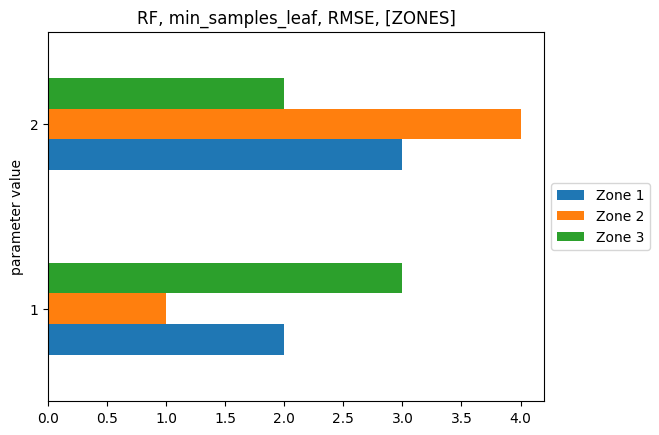

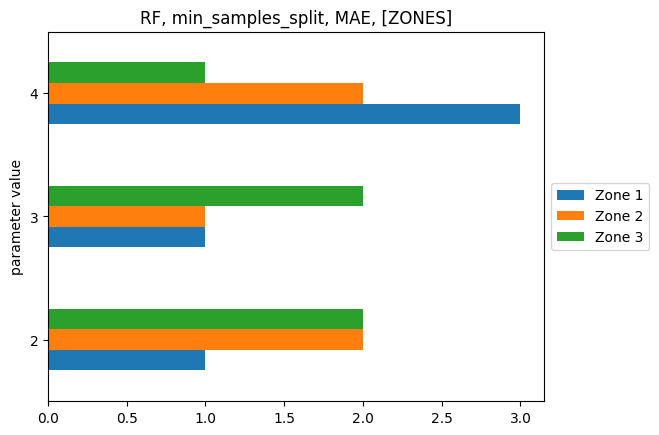

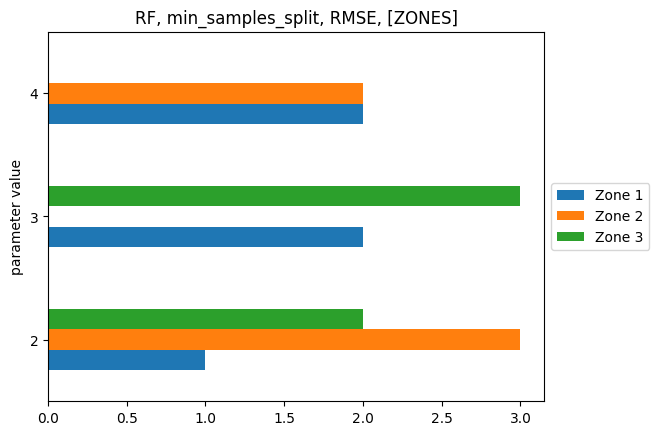

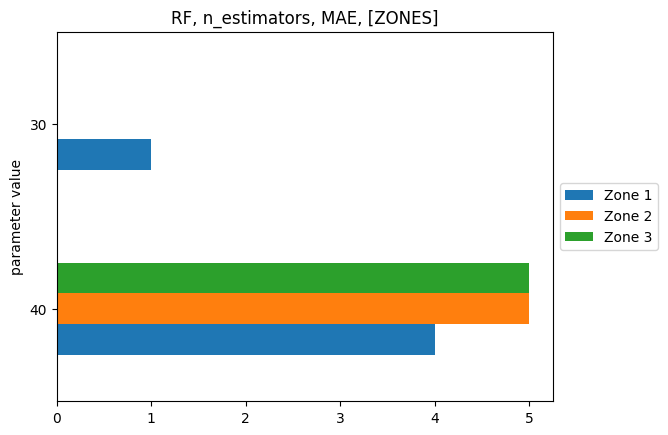

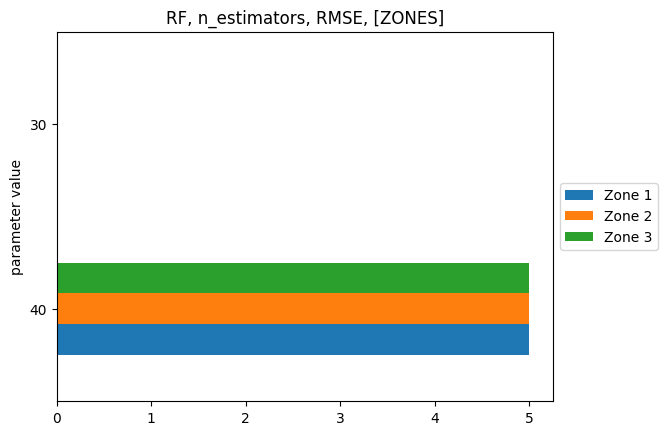

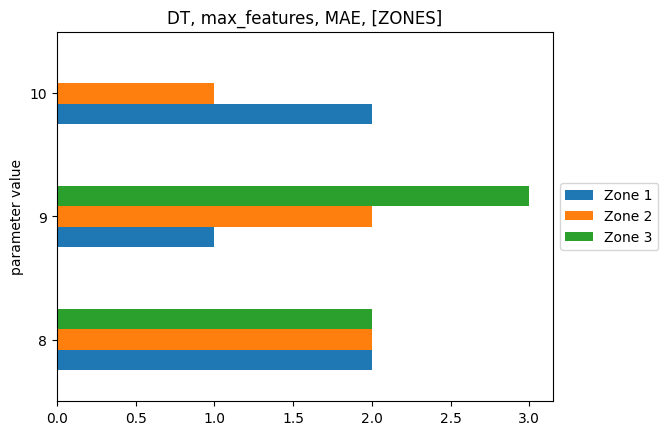

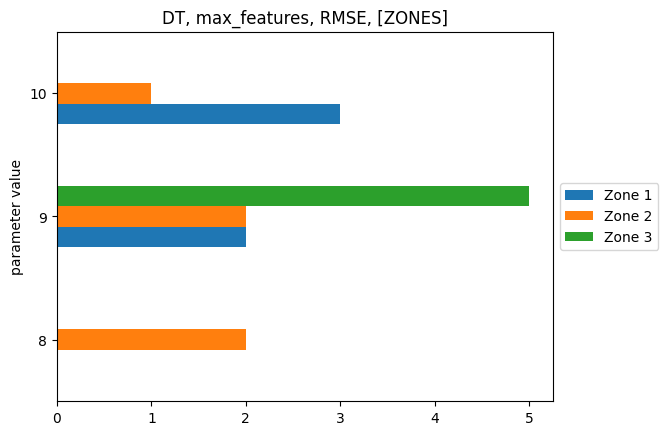

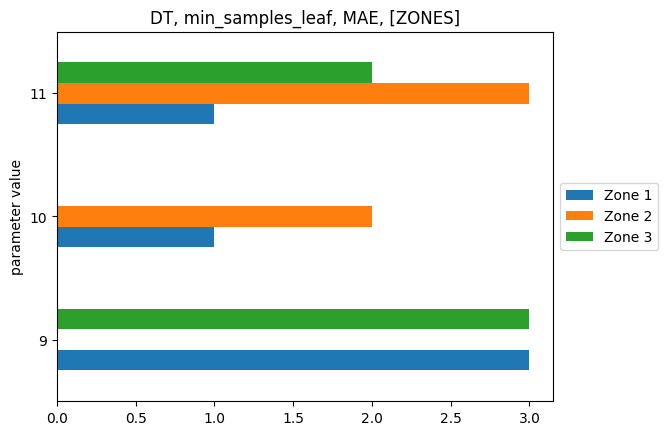

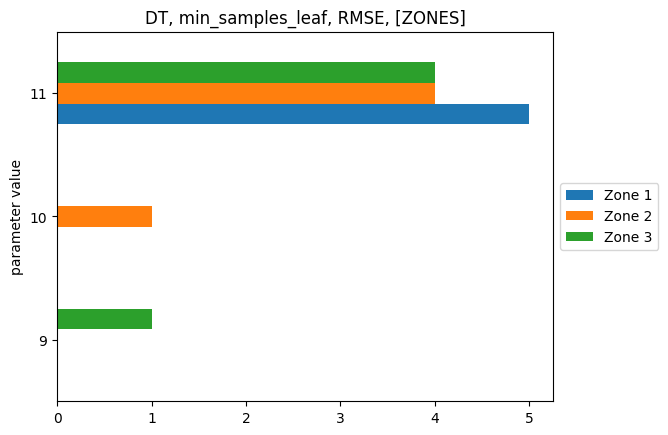

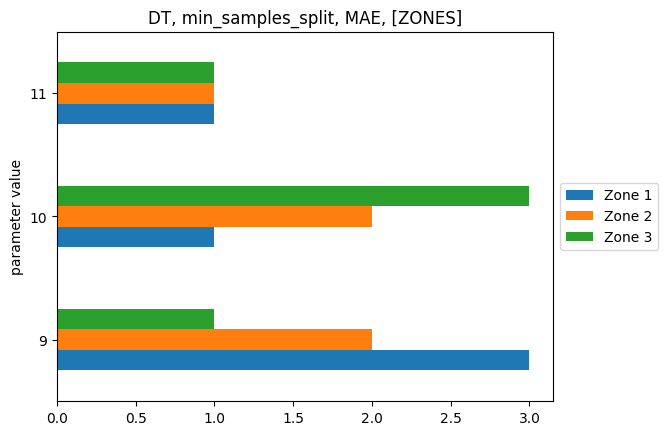

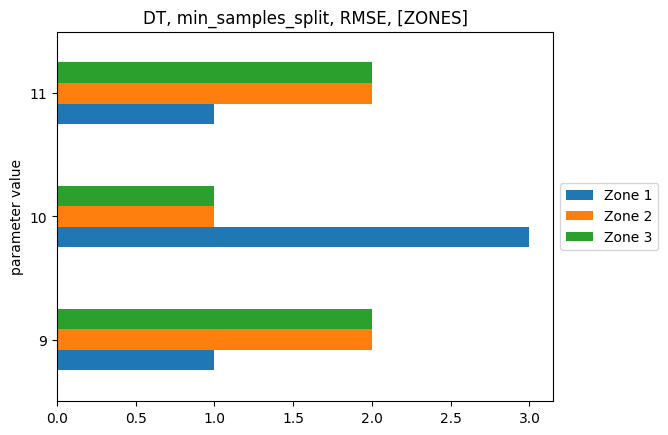

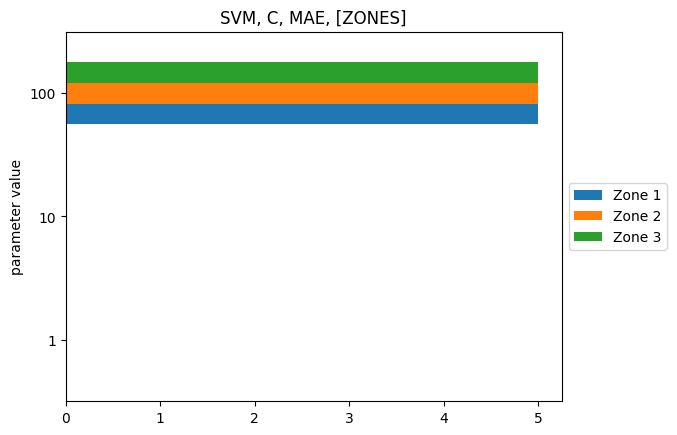

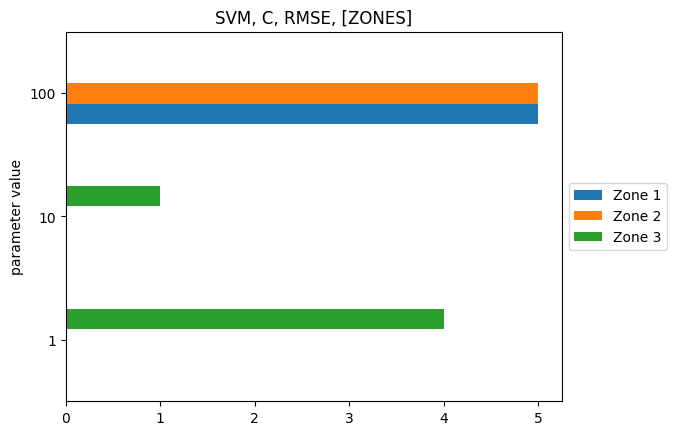

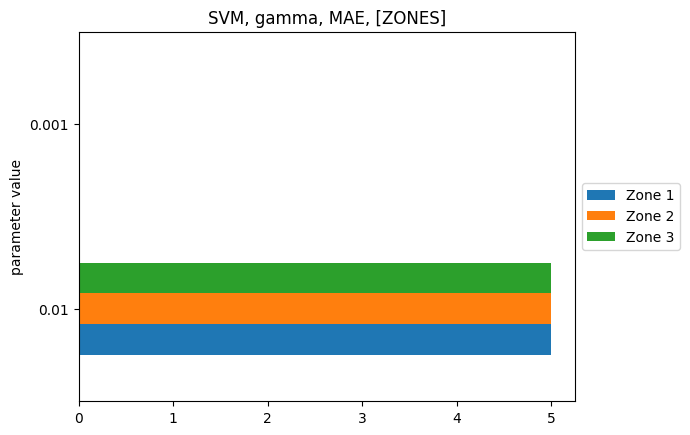

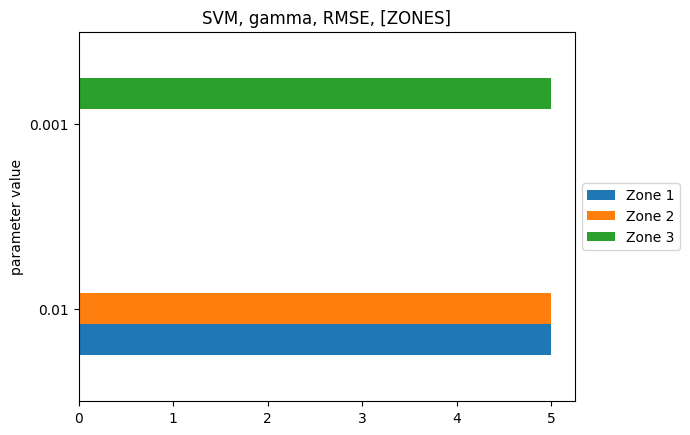

In [6]:
# First, extract the data needed for the bar charts from the data we collected during the computation

# We shall collect our extracted data in four dictionaries of dataframes. Each dataframe will be used to create
# one bar chart
mae_zone_dfs = {}
rmse_zone_dfs = {}
mae_total_dfs = {}
rmse_total_dfs = {}

# Compute column names for the dataframes that will hold data broken down by zone
col_names = ['parameter value']+[(f"Zone {z}") for z in (1,2,3)]

for est_abbr in best_params:
    
    # find all tuned values taken by each hyperparameter across all runs
    param_vals = {}
    all_dicts_list = []
    for zm_pair in zone_metric_pairs:
        dict_list = best_params[est_abbr][zm_pair]
        all_dicts_list += dict_list
        param_vals[zm_pair] = {key: [i[key] for i in dict_list] for key in dict_list[0]}
    all_param_vals = {key: [i[key] for i in all_dicts_list] for key in all_dicts_list[0]}
    all_param_vals = {p:list(set(all_param_vals[p])) for p in all_param_vals}
    
    # now build four dataframes for each hyperparameter for this model,
    # one for each combination of
    #   (A) error metric (MAE or RMSE)
    #   (B) whether to break the data down by zone or take totals across all zones
    mae_zone_dfs[est_abbr],rmse_zone_dfs[est_abbr],mae_total_dfs[est_abbr],rmse_total_dfs[est_abbr] = {},{},{},{}
    for p in all_param_vals:
        mae_zone_rows,rmse_zone_rows,mae_tot_rows,rmse_tot_rows = [],[],[],[]
        for v in all_param_vals[p]:
            mae_zone_row = [v]
            rmse_zone_row = [v]
            mae_total = 0
            rmse_total = 0
            for zm_pair in zone_metric_pairs:
                v_count = param_vals[zm_pair][p].count(v)
                if zm_pair[1]=='MAE':
                    mae_total+=v_count
                    mae_zone_row.append(v_count)
                else: # RMSE case
                    rmse_total+=v_count
                    rmse_zone_row.append(v_count)
            mae_tot_rows.append([v,mae_total])
            rmse_tot_rows.append([v,rmse_total])
            mae_zone_rows.append(mae_zone_row)
            rmse_zone_rows.append(rmse_zone_row)
            
        # create the dataframes from the lists of rows (we create four dataframes per hyperparameter)
        for rows,cols,dfs in [[mae_zone_rows,col_names,mae_zone_dfs],
                              [rmse_zone_rows,col_names,rmse_zone_dfs],
                              [mae_tot_rows,['parameter value','total'],mae_total_dfs],
                              [rmse_tot_rows,['parameter value','total'],rmse_total_dfs]]:
            df = pd.DataFrame(rows,columns=cols)
            dfs[est_abbr][p] = df.set_index('parameter value')
            
            
# Now make and display the bar charts

# bar charts for data from all zones combined
display(Markdown('## Totals'))
for est_abbr in mae_total_dfs:
    for p in mae_total_dfs[est_abbr]:
        for dfs,metric_abbr in [[mae_total_dfs,'MAE'],[rmse_total_dfs,'RMSE']]:
            dfs[est_abbr][p].plot.barh(title=f"{est_abbr}, {p}, {metric_abbr}, [TOTALS]").legend(loc='center left',
                                                                                      bbox_to_anchor=(1.0, 0.5))
            plt.xlabel("")
            plt.show()
            plt.close()        
 
# bar charts for data broken down by zone
display(Markdown('## Breakdowns'))
for est_abbr in mae_zone_dfs:
    for p in mae_zone_dfs[est_abbr]:
        for dfs,metric_abbr in [[mae_zone_dfs,'MAE'],[rmse_zone_dfs,'RMSE']]:
            dfs[est_abbr][p].plot.barh(title=f"{est_abbr}, {p}, {metric_abbr}, [ZONES]").legend(loc='center left',
                                                                                      bbox_to_anchor=(1.0, 0.5))
            plt.xlabel("")
            plt.show()
            plt.close()

Reviewing the above charts, we see that for some hyperparameters there is a clear preference for one value, whereas for others the picture is more mixed. For example, the number of trees in the random forest is 40 in nearly all of the sets of best hyperparameters, while minimum number of samples for a split in the Decision tree shows a much more even distribution across the values tried. Moreover, in the cases where there is not one clearly preferred value, there is usually a greater variability between the three zones. We might conclude that in these cases, the relevant hyperparameter does not have a great impact on the model's performance.